## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [354]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [355]:
filename='/Users/pra/Desktop/AnalyzeABTestResults 2/ab_data.csv'
df=pd.read_csv(filename)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [356]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [357]:
df['user_id'].unique().shape[0]

290584

d. The proportion of users converted.

In [358]:
df.query("converted==True").shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [359]:
df_to=df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]
df_cn=df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]
df_to.shape[0]+df_cn.shape[0]

3893

f. Do any of the rows have missing values?

In [360]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

So as all the entries are zeros there are no missing values in any of the coulmns.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [404]:
df2=df.drop(pd.concat([df_to,df_cn]).index)

In [405]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [406]:
df2['user_id'].unique().shape[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [407]:
repeated_user=df2.groupby(['user_id']).size().idxmax()
print (repeated_user)

773192


0c. What is the row information for the repeat **user_id**? 

In [408]:
df2.query("user_id=='773192'")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [409]:
df2.drop(labels=2893,axis=0,inplace=True)
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [410]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [411]:
df2.query("group=='control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [412]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [413]:
df2.query("landing_page=='new_page'").shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

answer:

Though the conversion rate of old page(control group) is slightly higher wheen compared to the
new page(treatment group) but we cannot finalize these because we are just calculating the 
probabilities and not considering many other factors like the duration etc and the change is very low so we cannot conclude which page is having more conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Answer:
H0 Null Hypothesis:pnew-pold<=0

In words we consider the new page is better if the differnece between conversion rate when new page is given in less than or equal to zero

H1 Alternative Hypothesis:pnew-pold>0

In words we consider the new page is better if the differnece between conversion rate when new page is given in greater than zero


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

Here the null hypothesis is pnew-pold=0 and the alternative hypothesis is pnew-pold!=0

a. What is the **convert rate** for $p_{new}$ under the null? 

In [418]:
#pnew conversion rate:
pnew=df2.converted.mean()
pnew

0.11959708724499628

The convertion rate is equal to nmean that is 0.1196 here we are assuming (pnew'=pold'=nmean) these are the terms in the null hypothesis stated above.

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [432]:
pold=df2.converted.mean()
pold

0.11959708724499628

c. What is $n_{new}$?

In [440]:
#the count for new and old
count_pages=df2.groupby(['landing_page']).size()# this gives the count of both new and old pafes together
n_new=count_pages[0]# this gives the count for the new pages
n_new

145310

d. What is $n_{old}$?

In [375]:
n_old=count_pages[1]# this gives the count for old pages
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [436]:
'''Here we are creating a new column named new_page_converted with a length equal to the new_pages count
calculated above and filling them with one's and zero's with the mean probability we calculated above for 
one's and remaing for zeros'''
new_page_converted=np.random.choice([1,0],size=n_new,p=[pnew,(1-pnew)])
new_page_converted.mean()

0.11818870002064552

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [437]:
'''Here we are creating a new column named old_page_converted with a length equal to the old_pages count
calculated above and filling them with one's and zero's with the mean probability we calculated above for 
one's and remaing for zeros'''
old_page_converted=np.random.choice([1,0],size=n_old,p=[pold,(1-pold)])
old_page_converted.mean()

0.11978743615512755

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [438]:
new_page_converted.mean() - old_page_converted.mean()

-0.0015987361344820261

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [389]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[pnew, (1-pnew)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[pold, (1-pold)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

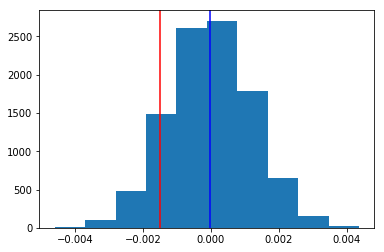

In [431]:
plt.hist(p_diffs)
plt.axvline(np.array(p_diffs).mean(),c='blue')
plt.axvline(-0.0015, c='red')

The plot obtained above is exact binnomial distribution which we expected
when we are taking samples from the data. And the mean of this distribution
is zero as shown witht the blue line this is what we assumed in null hypothesis
and the red line shows the real mean.

In [319]:
np.std(p_diffs)

0.0012003459803600813

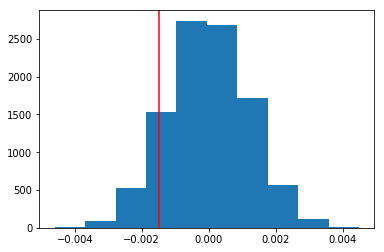

In [439]:
null_vals=np.random.normal(0,np.std(p_diffs),10000)
plt.hist(null_vals)
plt.axvline(-0.0015, c='red')


And as the real mean is coming from the null hypothesis we cannot reject it.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [422]:
p_new = df[df['landing_page']=='new_page']['converted'].mean()

print("Probability of conversion for new page (p_new):", p_new)
p_old = df[df['landing_page']=='old_page']['converted'].mean()

print("Probability of conversion for old page (p_old):", p_old)
a_diff=p_new-p_old
print (a_diff)

Probability of conversion for new page (p_new): 0.11880806551510564
Probability of conversion for old page (p_old): 0.1203863045004612
-0.0015782389853555567


In [423]:
#calculating the proportion of p_diffs greater than actual differce
(a_diff<np.array(p_diffs)).mean()

0.9024

This is p-value for the above system
The p-value is very large we cannot reject the null hypothesis
so the new page has more conversion rate than the old page.

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Answer:

In the above section j we have computed the proportion of data that is greater than real differnce and the proportion turned out to be 90.24 percentage as calculated above and we can say that the old page is much better than the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [310]:
import statsmodels.api as sm

convert_old = df2.query("landing_page=='old_page' and converted==True").shape[0]
convert_new = df2.query("landing_page=='new_page' and converted==True").shape[0]
n_old =df2[df2['landing_page']=='old_page'].shape[0] 
n_new = df2[df2['landing_page']=='new_page'].shape[0]
print("convert_old:", convert_old, "\nconvert_new:", convert_new,"\nn_old:", n_old,"\nn_new:", n_new)

convert_old: 17489 
convert_new: 17264 
n_old: 145274 
n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [442]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [443]:
#let us find out the significance of z-score
from scipy.stats import norm
print(norm.cdf(z_score))
print(norm.ppf(1-(0.05)))#considering 95 percent confidance interval

0.9050583127590245
1.6448536269514722


Answer:
The obtained z-score is 1.31 which is smaller than the critical value which is 1.644 so we failed to 
reject the null hypothesis, so we have new page conversion rate is greater than the old rate. 
we find that old pages are only minutely better than new pages. These obtained values go in the same direction with the findings in parts j. and k. 


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Answer:

I would like to use logistic regression because this is mainly helpful in prdicting the binary out come and as our ressults are also conversion or no converstion that is a binary output so we can use logisrtic regression here.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [250]:
# Here we are adding intercept column into the data frame for carrying out regression analysis
df2['intercept']=1
df2[['ab_extra','ab_page']]=pd.get_dummies(df['group'])#creating dummy varibles
df2.drop(['ab_extra'],axis=1, inplace=True)#droping one of them for maintaining the rank
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [312]:
#fitting the model using logistic regression for preddicting converted column using intercept and ab_page
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
r=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [313]:
#getting the summary of the above model
r.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-15 06:43 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

Answer:
The p-value associated with ab_page is 0.190

In Part II, the p-value was calculated where the null hypothesis was pnew-pold>=0, and the alternative was the old page converted more than or equal to the new page pold-pnew>0.

In Part III, we used variables, and used a linear model to determine the p-value. The null hypothesis was that the difference between the pages is equal to 0 pnew=pold , and the alternative hypothesis was the difference between the pages is greater or less than 0 pnew!=pold.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Answer:

As here we are considering only one column for the regression analysis there wont be any problem if we add few more items for the analysis that are related in determing the prediction. But we should not add the columns which donot have
nay influence on the depended term and also we should make sure that there wont be any multi collinearity because of the newly added columns.
If we add linearlt related terms then the R2 value reaches to one and we add non related terms then w ewill be having reduced R2.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [314]:
#reading the data
countries_df = pd.read_csv('/Users/pra/Desktop/AnalyzeABTestResults 2/countries.csv')
#combinign the two tables into single table
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [315]:
### Create the necessary dummy variables for the country
df_country=pd.get_dummies(data=countries_df, columns=['country'])
df_country.head()

,user_id,country_CA,country_UK,country_US
0,834778,0,1,0
1,928468,0,0,1
2,822059,0,1,0
3,711597,0,1,0
4,710616,0,1,0


In [317]:
#combining the new dummie variables table to the original table using user_id
df_new =df_country.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country_CA,country_UK,country_US,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,
834778,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [427]:
### Fitting the Linear Model And Obtain the Results
lm=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','country_UK','country_US']])
r=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [428]:
#getting the summamry of the above fitted model
r.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-15 09:46 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
country_UK     0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
country_US     0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

So from the above summary report we can see that the p values are much higher and also R-squared values is very less so adding the 
new dummies realted to countries and using them in the regression did not help the system in better predictions.

In [441]:
df2.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

In [429]:
np.exp(0.0506),np.exp(0.0408)

(1.0519020483004984, 1.0416437559600236)

So from the conversion rates obtained here are almoct equal to each other so there is no advantage is 
adding of the new dummies related to country in prediction.

<a id='conclusions'></a>
## Conclusions

First thing to me noted is the experiment is carried out without any baises related to the distribution of the new and old pages
among the people this can be known from the probabilities found for a user landing on either page is almost equal to 0.5.
And from the plot we ploted above and the proportion of simulated differnce greater than actual differnce is very high of about 90 percent and we can see that the p-value is 0.9024 which actuallt should be less than the alpha that is type1 error of 5 percent and from this we can say that the company has to keep the old page rather than changing to new page and also should work more on new page to make it much better so that they can change it.
And from the final part of adding new terms like country for getting more better prediction it really didn't help much because we can see that we ahve the same convertion rate for both.
And finally we are not  having the good information in rejecting the null hypothesis and new page does not do good at all when compared to old page.